# Intermediate component separation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

import healpy as hp
import pysm

from fgbuster.observation_helpers import get_instrument, get_sky  # Predefined instrumental and sky-creation configurations
from fgbuster.visualization import corner_norm

# Imports needed for component separation
from fgbuster import (CMB, Dust, Synchrotron,  # sky-fitting model
                      basic_comp_sep)  # separation routine

## Input frequency maps
You have some frequency maps to clean, they can be either data or simulations.

### Simple case
Let's simulate a simple sky with `pysm`. ForeGroundBuster adds a couple of functions that make the process even easier.

In [3]:
NSIDE = 64
sky_conf_simple = get_sky(NSIDE, 'c1d0s0') 
instrument = pysm.Instrument(get_instrument('cmbs4', NSIDE))
freq_maps_simple, noise = instrument.observe(pysm.Sky(sky_conf_simple), write_outputs=False)

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


nu (GHz) | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) 

0020.00 | 16.66 | 13.60 | 00.00 
0030.00 | 10.62 | 08.67 | 00.00 
0040.00 | 10.07 | 08.22 | 00.00 
0085.00 | 02.01 | 01.64 | 00.00 
0095.00 | 01.59 | 01.30 | 00.00 
0145.00 | 04.53 | 02.03 | 00.00 
0155.00 | 04.53 | 02.03 | 00.00 
0220.00 | 11.61 | 05.19 | 00.00 
0270.00 | 15.84 | 07.08 | 00.00 
Instrument attribute 'pixel_indices' not set.


We will focus on polarization-only component separation

In [4]:
freq_maps_simple = freq_maps_simple[:, 1:]  # Select polarization

### Spatially varying spectral indices
Let's prepare also maps with spatially varying spectral indices. Similarly to the simple case above, we run the following (notice `d1s1`)

In [5]:
NSIDE_PATCH = 8
sky_conf_vary = get_sky(NSIDE, 'c1d1s1')

We can still modify the sky configuration. In this case, we change the nside over which the spectral indices are allowed to vary

In [6]:
for comp, param in [('dust', 'spectral_index'),
                    ('dust', 'temp'),
                    ('synchrotron', 'spectral_index')
                   ]:
    spectral_param = sky_conf_vary[comp][0][param]
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param, NSIDE_PATCH),
                                    NSIDE)

Here is how they look like in constant and varying case. The rightmost plot shows the full resolution `pysm` template.

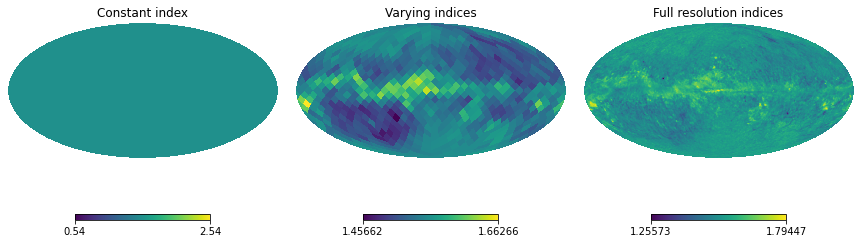

In [7]:
comp = 'dust'
param = 'spectral_index'
hp.mollview(sky_conf_simple[comp][0][param], sub=(1,3,1), title='Constant index')
hp.mollview(sky_conf_vary[comp][0][param], sub=(1,3,2), title='Varying indices')
hp.mollview(get_sky(NSIDE, 'c1d1s1')[comp][0][param], sub=(1,3,3), title='Full resolution indices')

And now we generate the maps and select polarization

In [8]:
freq_maps_vary, _ = instrument.observe(pysm.Sky(sky_conf_vary), write_outputs=False)
freq_maps_vary = freq_maps_vary[:, 1:] # Select polarization

nu (GHz) | sigma_I (uK_CMB amin) | sigma_P (uK_CMB amin) | FWHM (arcmin) 

0020.00 | 16.66 | 13.60 | 00.00 
0030.00 | 10.62 | 08.67 | 00.00 
0040.00 | 10.07 | 08.22 | 00.00 
0085.00 | 02.01 | 01.64 | 00.00 
0095.00 | 01.59 | 01.30 | 00.00 
0145.00 | 04.53 | 02.03 | 00.00 
0155.00 | 04.53 | 02.03 | 00.00 
0220.00 | 11.61 | 05.19 | 00.00 
0270.00 | 15.84 | 07.08 | 00.00 
Instrument attribute 'pixel_indices' not set.


## Component separation
The sky model we fit for is defined as a list of `Component` objects. They can be easily build from analytic SEDs, but for popular component types these are already implemented.

In [9]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [10]:
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.6, 22.]
components[2].defaults = [-2.7]

We are now ready to perform the component separation

In [11]:
result = basic_comp_sep(components, instrument, freq_maps_simple,
                        options=dict(disp=True),  # verbose output
                        )

Minimization started
Iter 1	x = [ 1.4398246  21.99769057 -2.89355285]	First -logL = -16985919555.231621	N Eval = 3	Iter sec = 0.14	Cum sec = 0.14


Iter 2	x = [ 1.50989347 21.99884214 -2.98531374]	Delta(-logL) = -1057698.835516	N Eval = 5	Iter sec = 0.09	Cum sec = 0.23


Iter 3	x = [ 1.55090487 19.34011632 -2.9876152 ]	Delta(-logL) = -7895.963097	N Eval = 28	Iter sec = 1.00	Cum sec = 1.24
Iter 4	x = [ 1.55429662 19.1265034  -2.98794623]	Delta(-logL) = -225.213802	N Eval = 31	Iter sec = 0.13	Cum sec = 1.37


Iter 5	x = [ 1.55488801 19.16655163 -2.99317377]	Delta(-logL) = -7575.893063	N Eval = 34	Iter sec = 0.13	Cum sec = 1.50
Iter 6	x = [ 1.55604792 19.19925541 -3.00062835]	Delta(-logL) = -3999.583338	N Eval = 35	Iter sec = 0.04	Cum sec = 1.54
Iter 7	x = [ 1.55446171 19.28303813 -3.00078795]	Delta(-logL) = -40.973251	N Eval = 37	Iter sec = 0.09	Cum sec = 1.63
Iter 8	x = [ 1.5514907  19.43189606 -3.00082056]	Delta(-logL) = -74.498404	N Eval = 38	Iter sec = 0.04	Cum sec = 1.67


Iter 9	x = [ 1.54542388 19.73143157 -3.00063121]	Delta(-logL) = -118.354778	N Eval = 39	Iter sec = 0.04	Cum sec = 1.71
Iter 10	x = [ 1.53762927 20.11698577 -3.000069  ]	Delta(-logL) = -32.496866	N Eval = 40	Iter sec = 0.04	Cum sec = 1.76
Iter 11	x = [ 1.54051515 19.97497228 -3.00009465]	Delta(-logL) = -14.257454	N Eval = 41	Iter sec = 0.04	Cum sec = 1.80
Iter 12	x = [ 1.54004647 19.99816056 -3.00002227]	Delta(-logL) = -0.717218	N Eval = 42	Iter sec = 0.04	Cum sec = 1.84
Iter 13	x = [ 1.53995829 20.00239101 -3.00000051]	Delta(-logL) = -0.037277	N Eval = 43	Iter sec = 0.04	Cum sec = 1.89


Iter 14	x = [ 1.53997188 20.00160477 -2.99999947]	Delta(-logL) = -0.002012	N Eval = 44	Iter sec = 0.04	Cum sec = 1.93
Iter 15	x = [ 1.53999905 20.00005655 -2.99999964]	Delta(-logL) = -0.001406	N Eval = 45	Iter sec = 0.04	Cum sec = 1.98
Iter 16	x = [ 1.54000003 19.99999871 -2.99999994]	Delta(-logL) = -0.000010	N Eval = 46	Iter sec = 0.04	Cum sec = 2.02
Iter 17	x = [ 1.54000001 19.99999958 -3.        ]	Delta(-logL) = -0.000017	N Eval = 47	Iter sec = 0.04	Cum sec = 2.06


         Current function value: -16986997232.059130
         Iterations: 17
         Function evaluations: 86
         Gradient evaluations: 74


The input spectral parameters are recovered to numerical accuracy

In [12]:
import numpy as np
inputs = [sky_conf_simple[comp][0][param][0]
          for comp, param in [('dust', 'spectral_index'),
                              ('dust', 'temp'),
                              ('synchrotron', 'spectral_index')]
         ]
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result.params, result.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000


Their semi-analytic covariance is also provided, but remember that it is accurate only in the high signal-to-noise regime

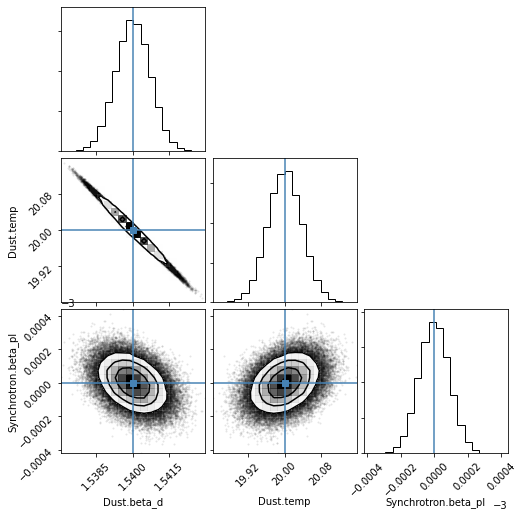

In [13]:
corner_norm(result.x, result.Sigma, labels=result.params, truths=inputs)

The amplitudes of the components are stacked in the `s` attribute and they are in the same format of the input frequency maps: Q and U healpix maps, in this case. Here is the U Stokes parameter for each of the components.

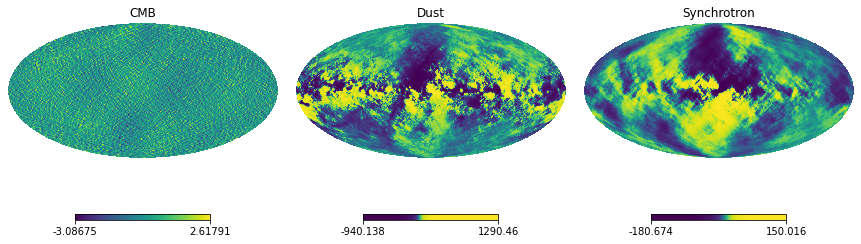

In [14]:
hp.mollview(result.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

By taking the difference with the input template, we see that the error in the reconstruction is negligible.

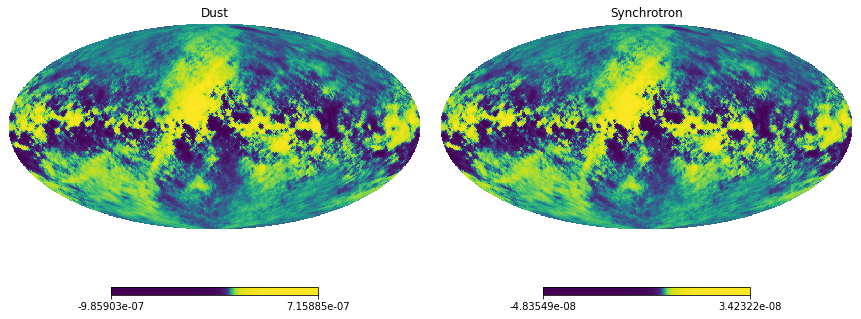

In [15]:
hp.mollview(result.s[1,1] 
            - sky_conf_simple['dust'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 353.),
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result.s[2,1] 
            - sky_conf_simple['synchrotron'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 23.), 
            title='Synchrotron', norm='hist', sub=(1,2,2))

## Component separation with varying indices
We now fit the spectral parameters independently over patches corresponding to healpix pixels with a given nside

In [16]:
nside_fit = NSIDE_PATCH
result_vary = basic_comp_sep(components, instrument, freq_maps_vary, nside_fit)

As in the previous case, the amplitudes of the components are stacked in the `s`.

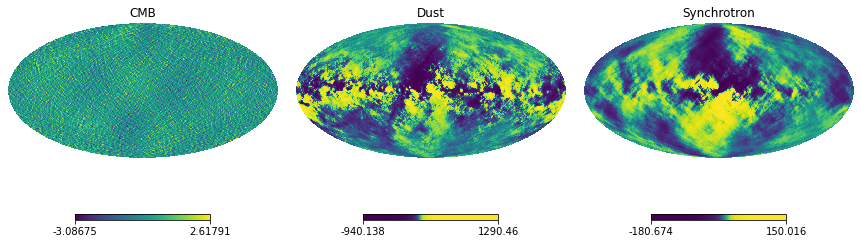

In [17]:
hp.mollview(result_vary.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_vary.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_vary.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

When we take the difference with the input templates, the residuals are patchy. This is because the independent fit of the non-liner parameters has a different level of numerical accuracy for different patches. However, note that in all cases residuals are negligible: also this multi-patch cleaning has very high accuracy. 

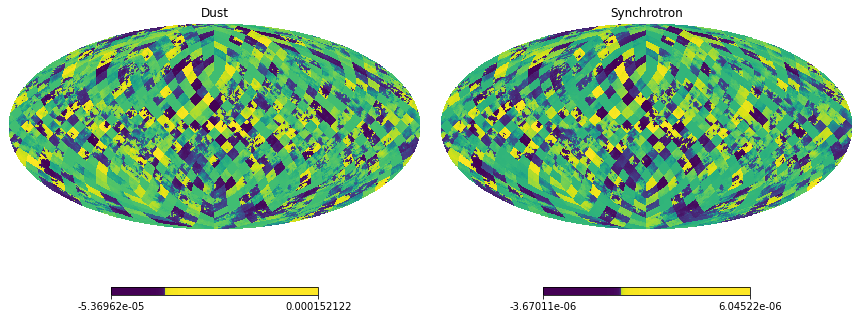

In [18]:
hp.mollview(result_vary.s[1,1] - 
            sky_conf_vary['dust'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 353.),
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result_vary.s[2,1] - 
            sky_conf_vary['synchrotron'][0]['A_U'] * pysm.convert_units('K_RJ', 'K_CMB', 23.), 
            title='Synchrotron', norm='hist', sub=(1,2,2))

The same is true for the non-linear parameters. Here are their reconstructed maps.

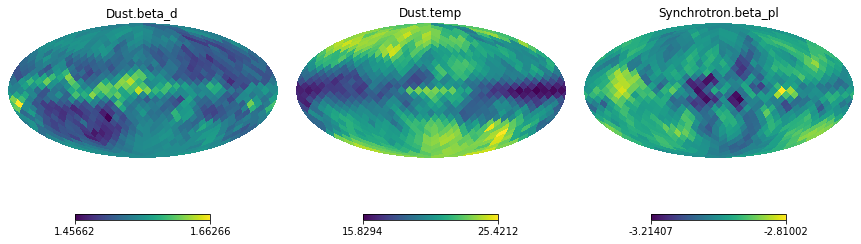

In [19]:
for i, par in enumerate(result.params):
    hp.mollview(result_vary.x[i], title=par, sub=(1,3,i+1))

And here is the difference with the input templates.

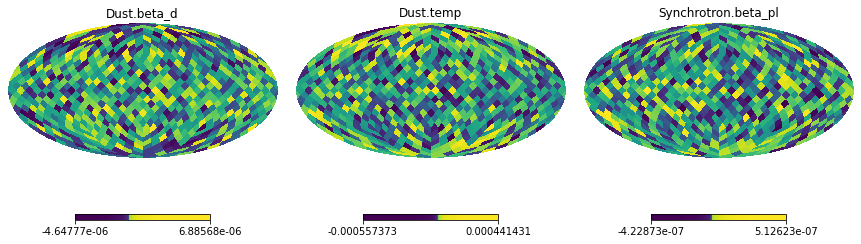

In [20]:
hp.mollview(hp.ud_grade(result_vary.x[0], NSIDE) - 
            sky_conf_vary['dust'][0]['spectral_index'],
            title=result.params[0], norm='hist', sub=(1,3,1))
hp.mollview(hp.ud_grade(result_vary.x[1], NSIDE) - 
            sky_conf_vary['dust'][0]['temp'],
            title=result.params[1], norm='hist', sub=(1,3,2))
hp.mollview(hp.ud_grade(result_vary.x[2], NSIDE) - 
            sky_conf_vary['synchrotron'][0]['spectral_index'],
            title=result.params[2], norm='hist', sub=(1,3,3))